# Line Generation Project


In [62]:
##!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

##!pip install scikit-learn

## Import Libraries

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import os
import datetime
import torch.nn.functional as F
import shutil



# choisir gpu si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Import Dataset from Folder

In [64]:
path = "/Box_Line/render/Dataset"

# Lister et trier les fichiers par ordre alphabétique
files = [f for f in os.listdir(path) if f.endswith('.png')]
files_sorted = sorted(files)  # Tri alphabétique fonctionne si noms = box_0001.png, etc.

# Afficher pour vérifier l'ordre
for f in files_sorted:
    print(f)

box_0001.png
box_0002.png
box_0003.png
box_0004.png
box_0005.png
box_0006.png
box_0007.png
box_0008.png
box_0009.png
box_0010.png
box_0011.png
box_0012.png
box_0013.png
box_0014.png
box_0015.png
box_0016.png
box_0017.png
box_0018.png
box_0019.png
box_0020.png
box_0021.png
box_0022.png
box_0023.png
box_0024.png
box_0025.png
box_0026.png
box_0027.png
box_0028.png
box_0029.png
box_0030.png
box_0031.png
box_0032.png
box_0033.png
box_0034.png
box_0035.png
box_0036.png
box_0037.png
box_0038.png
box_0039.png
box_0040.png
box_0041.png
box_0042.png
box_0043.png
box_0044.png
box_0045.png
box_0046.png
box_0047.png
box_0048.png
box_0049.png
box_0050.png
box_0051.png
box_0052.png
box_0053.png
box_0054.png
box_0055.png
box_0056.png
box_0057.png
box_0058.png
box_0059.png
box_0060.png
box_0061.png
box_0062.png
box_0063.png
box_0064.png
box_0065.png
box_0066.png
box_0067.png
box_0068.png
box_0069.png
box_0070.png
box_0071.png
box_0072.png
box_0073.png
box_0074.png
box_0075.png
box_0076.png
box_0077.png

## Print some Images

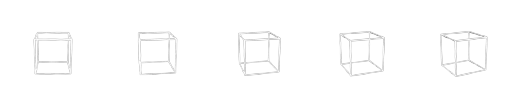

500


In [65]:
# Créer une liste avec toutes les images du dossier importé
images = [Image.open(os.path.join(path, f)) for f in files_sorted]


# Affichage des 5 premières images
for i in range(min(5, len(images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')  # Supprimer les axes

plt.show()
print(len(images))

## Set Variables

In [66]:
# nombre d'achantillons que le modèle traite en une itération
batch_size = 16

# graine aléatoire permettant de rendre le code reproductible, obtenir les mêmes résultats à chaque exécution
seed = 42

# 10 % des données seront utilisés pour le jeu de validation
validation_split = 0.1

## Reproducibility

In [67]:
# fixe la graine pour les tirages aléatoires dans Pytorch (poids initiaux, dataloader, etc)
torch.manual_seed(seed)

# fixe la graine pour les opérations aléatoires de la bib Python (random.shuffle)
random.seed(seed)

## Images Transformation

In [68]:
# Transformation des images
train_transform = transforms.Compose ([

    # redimensionne les images
    transforms.Resize((256, 256)),
 
    # Augmentation de données
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.Grayscale(num_output_channels=1),

    # [0,255] → CHW [0.0 , 1.0] conversion d'image PIL/numpy en tenseurs Pytorch (channel, Height, Width)
    transforms.ToTensor(),

    # Normalisation pour que la plage passe de [0, 1] à [-1, 1]
    # Mieux pour les autoencodeurs car permet une distribution autour de 0 et aide la convergence du modèle
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transform = transforms.Compose ([

    transforms.Resize((256, 256)),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

## Dataset Class

In [69]:
class CubeImageInpaintingDataset(Dataset):
    def __init__(self, image_paths, image_size, patch_size, num_masked_patches,mask_ratio=0.25, transform=None):


        # Liste des chemins des images .png
        self.image_paths = image_paths

        self.image_size = image_size # Taille à laquelle on redimensionne les images (ex: 128)

        self.img_names = [os.path.basename(p) for p in image_paths]

        self.patch_size = patch_size

        self.num_masked_patches = num_masked_patches

        self.mask_ratio = mask_ratio

        self.transform = transform


    def __len__(self):
        # Renvoie le nombre total d'images dans le dataset
        return len(self.image_paths)

    # fonction qui prend une image en tenseur er renvoie une version masquée
    def apply_patch_mask(self, img_tensor):

            # on clone l'image et on récupère la hauteur et largeur
            img = img_tensor.clone()
            _, H, W = img.shape

            # nombre de patch horizontal (x) et vertical (y) 
            # // signifie qu'on ne prend que les patchs qui tiennent entièrement dans l'img
            num_patches_x = W // self.patch_size
            num_patches_y = H // self.patch_size
        
            # nb total de patch
            total_patches = num_patches_x * num_patches_y
    
            # Choisir aléatoirement les patchs à masquer
            num_to_mask = max(1, int(total_patches * self.mask_ratio))
            mask_indices = torch.randperm(total_patches)[:num_to_mask]

        
            for idx in mask_indices:
                row = idx // num_patches_x
                col = idx % num_patches_x

                # La zone masquée est un carré de taille patch_size × patch_size
                # img[:, ...] : on masque tous les canaux (R, G, B)
                # On met la valeur à -1.0 (noir si l’image a été normalisée entre [-1, 1])
                img[:, 
                    row * self.patch_size : (row + 1) * self.patch_size, 
                    col * self.patch_size : (col + 1) * self.patch_size] = -1.0
    
            return img

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_name = os.path.basename(img_path)
    
        img = Image.open(img_path).convert("RGB")
    
        # Transforme l'image (ex: resize + tensor + normalize)
        original_img = self.transform(img) if self.transform else img
    
        # Applique le masque sur l'image transformée
        masked_img = self.apply_patch_mask(original_img)
    
        return masked_img, original_img, img_name



## Dataloader

In [70]:
def create_dataloaders(path, image_size, patch_size, batch_size,num_masked_patches,
                       train_split=0.7, val_split=0.1, seed=42, num_workers=0,
                       train_transform=None, val_test_transform=None):

    # Lister les images
    image_paths = image_paths = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.png')])


    # # Split train / temp => 70 % au train
    # train_paths, temp_paths = train_test_split(
    #     image_paths, train_size=train_split, random_state=seed
    # )

    # # Ratio du val set 0.1 / (1 - 0.7) = 0.33
    # val_size_ratio = val_split / (1 - train_split)

    # # Ensuite on divise les 30 % restant entre le val et le test set
    # # val = 0.33 de temp = 10 % du total et test = 0.67 de temp = 20 % du total
    # val_paths, test_paths = train_test_split(
    #     temp_paths, test_size=1 - val_size_ratio, random_state=seed
    # )

    # Création des datasets
    total_images = len(image_paths)
    train_end = int(train_split * total_images)
    val_end = int((train_split + val_split) * total_images)

    # Découpage séquentiel
    train_paths = image_paths[:train_end]
    val_paths = image_paths[train_end:val_end]
    test_paths = image_paths[val_end:]

    

    # Créer les datasets avec les transforms passés en argument
    train_dataset = CubeImageInpaintingDataset(train_paths, image_size, patch_size, num_masked_patches, transform=train_transform)
    val_dataset = CubeImageInpaintingDataset(val_paths, image_size, patch_size, num_masked_patches, transform=val_test_transform)
    test_dataset = CubeImageInpaintingDataset(test_paths, image_size, patch_size, num_masked_patches, transform=val_test_transform)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset


## Dataset Instance and Dataloader Variables

In [71]:

# On applique le split sur le dataset avec tous les paramètres
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = create_dataloaders(path,image_size=256, patch_size=50, batch_size=32,
                                                           num_masked_patches=2, train_transform=train_transform, val_test_transform=val_test_transform)


## Visualization


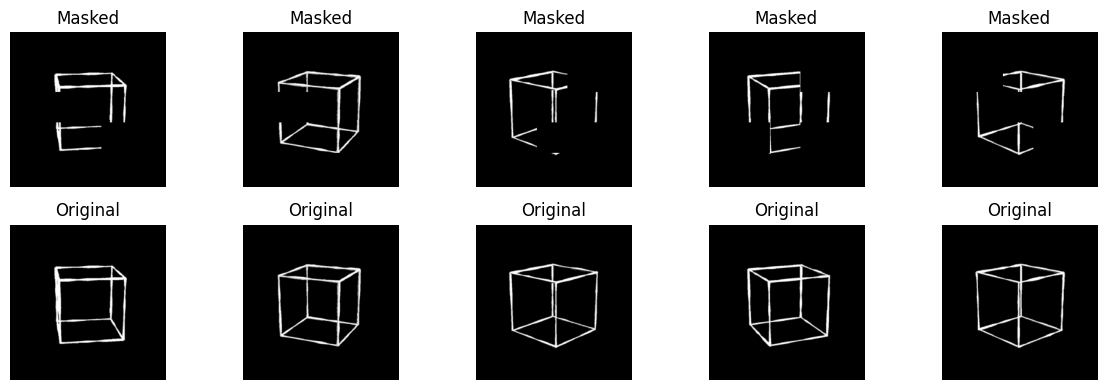

In [72]:

# Récupère un batch du train_loader
masked, original, names  = next(iter(train_loader))


# Dénormalisation si l'image est normalisée entre [-1, 1]
def denorm(tensor):
    return (tensor * 0.5) + 0.5

# Affichage image 12 pouces sur 4
plt.figure(figsize=(12, 4))
for i in range(5):

    # 2 lignes, 5 colonnes
    plt.subplot(2, 5, i+1)

    #Change les dimensions de (C, H, W) en (H, W, C) => format attendu par matplotlib
    plt.imshow(denorm(masked[i]).permute(1, 2, 0).cpu()) # déplace au cpu pour que imshow puisse la lire
    plt.axis("off")
    plt.title("Masked")

    plt.subplot(2, 5, i+6)
    plt.imshow(denorm(original[i]).permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Original")
plt.tight_layout()
plt.show()


## Batch Visualization

In [73]:
def visualize_masked_vs_original(dataloader, n_images=5):
    masked, original, names = next(iter(dataloader))

    def denorm(tensor):
        return tensor * 0.5 + 0.5

    plt.figure(figsize=(n_images * 2, 4))
    for i in range(n_images):
        # Image masquée
        plt.subplot(2, n_images, i + 1)
        plt.imshow(denorm(masked[i]).permute(1, 2, 0).cpu() )
        plt.axis("off")
        plt.title("Masked")

        # Image originale
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(denorm(original[i]).permute(1, 2, 0).cpu())
        plt.axis("off")
        plt.title("Original")

    plt.tight_layout()
    plt.show()


## Visualize Train_loader

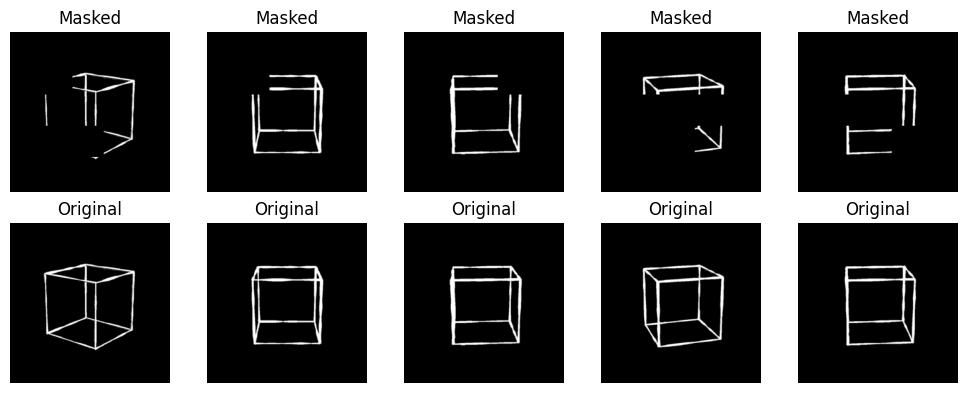

350


In [74]:
visualize_masked_vs_original(train_loader, n_images=5)
print(len(train_loader.dataset))

## Visualize Val_loader

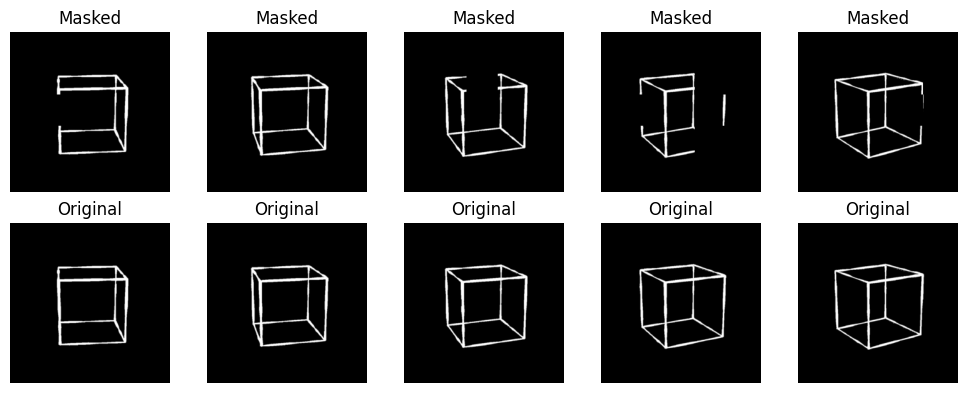

49


In [75]:
visualize_masked_vs_original(val_loader, n_images=5)
print(len(val_loader.dataset))

## Visualize Test_loader

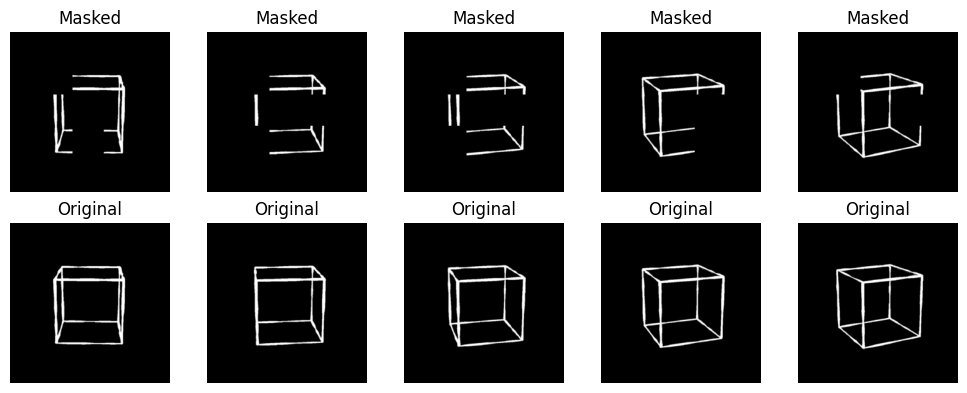

101


In [76]:
visualize_masked_vs_original(test_loader, n_images=5)
print(len(test_loader.dataset))

In [77]:
print(masked.min(), masked.max())

tensor(-1.) tensor(1.)


## Neural Network

In [78]:
import torch.nn as nn

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encodeur (Compression)
        # Réduction de la taille de l'image pour extraire des caractéristiques globales
        # tout en augmentant la profondeur du reseau


        # in_chanel = 3, out_channel = 64, kernel_size = 4, stride=2, padding = 1)
        # img RGB, 64 canaux de sorties, taille du filtre, déplacement de 2 pixels (H et v), ajoute 1 pixel de bordure autour de l'image
        # Pour conserver plus d'info en bordure


        self.encoder = nn.Sequential(

        # in_chanel = 3, out_channel = 64, kernel_size = 4, stride=2, padding = 1)
        # img RGB, 64 canaux de sorties, taille du filtre=4, déplacement de 2 pixels (H et v), ajoute 1 pixel de bordure autour de l'image
        # Pour conserver plus d'info en bordure

            nn.Conv2d(3, 64, 4, 2, 1),         # 256 -> 128 downsample car stride = 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, 4, 2, 1),       # 128 -> 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),      # 64 -> 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),      # 32 -> 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(512, 1024, 4, 2, 1), # 16 → 8
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 2048, 4, 2, 1), # 8 → 4 (bottleneck très compressé)
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
        )




        # ------------------------------------------------------------------------------------------------------------------------------

        # Décodeur
        # Upsampling de la taille de l'image => permet de reconstruire l’image originale à partir de la représentation compressée.

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(2048, 1024, 4, 2, 1), # 4 → 8
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1), # 8 → 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1), # 16 -> 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout2d(0.25),


            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 32 -> 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),


            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 64 -> 128
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),


            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # 128 -> 265
            nn.Tanh(),
        )



    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model, Adam Optimizer and Learning Rate

In [79]:
# Modèle
model = InpaintingAutoencoder().to(device)

# La Loss Function
criterion = nn.MSELoss()


# Optimizer Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training Loop

In [80]:
# def train_epoch(model, train_loader, optimizer, criterion): # entrainement du modèle sur un epoch

#     model.train() # met le modèle en mode entrainement

#     running_loss = 0.0 # accumulateur pour la perte totale de l'epoch

#     for masked, original, names in train_loader: # on boucle sur le train dataset

#         # envoie les images masquées et originales au gpu
#         masked = masked.to(device)
#         original = original.to(device)

#         optimizer.zero_grad() # réinitialise les gradients
#         output = model(masked) # passe le batch dans le modèle

#         loss = criterion(output, original) # calcule la perte 

#         loss.backward() # rétropropagation 
#         optimizer.step() # mise à jour des poids 
#         running_loss += loss.item() # ajoute la perte au total

#     return running_loss / len(train_loader) # renvoie la perte moyenne pour l'epoch


# def evaluate(model, val_loader, criterion): # evalue le modèle sur le val et test dataset

#     model.eval()  # modèle en mode évaluation (désactive dropout, batchnorm)
#     val_loss = 0.0

#     with torch.no_grad():  # désactive le calcul des gradients 

#         # Pas de rétropropagation ici
#         for masked, original, _ in val_loader:
#             masked = masked.to(device)
#             original = original.to(device)
#             output = model(masked)
#             loss = criterion(output, original)
#             val_loss += loss.item()

#     return val_loss / len(val_loader) # renvoie la val_loss moyenne sur tout le dataset

# num_epochs = 200

# for epoch in range(num_epochs): 
#     train_loss = train_epoch(model, train_loader, optimizer, criterion)
#     val_loss = evaluate(model, val_loader, criterion)
#     print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


# test_loss = evaluate(model, test_loader, criterion)
# print(f" Final Test Loss: {test_loss:.4f}")

## Save Model Training

In [81]:
# # SAUVEGARDE DU MODÈLE ENTRAINÉ
# save_dir = "checkpoints"
# os.makedirs(save_dir, exist_ok=True)

# # Timestamp (format : AAAAMMJJ-HHMMSS)
# timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# # Création du nom de fichier unique avec l'époque + le timestamp
# model_path = os.path.join(save_dir, f"model_epoch{num_epochs}_{timestamp}.pth")

# # Sauvegarde du modèle et des métadonnées
# torch.save({
#     'epoch': num_epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_loss': train_loss,
#     'val_loss': val_loss,
# }, model_path)

# print(f" Modèle sauvegardé avec succès à : {model_path}")


## Load Model

In [82]:

# Recrée l'architecture du modèle
model = InpaintingAutoencoder()

# Trouve le dernier checkpoint dans le dossier "checkpoints/"
checkpoint_dir = "checkpoints"
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
assert checkpoints, "Aucun checkpoint trouvé dans le dossier checkpoints."

# Trie par date de modification (du plus ancien au plus récent)
checkpoints = sorted(checkpoints, key=lambda f: os.path.getmtime(os.path.join(checkpoint_dir, f)))

# Le dernier checkpoint
latest_checkpoint_path = os.path.join(checkpoint_dir, checkpoints[-1])
print(f"Chargement du dernier checkpoint : {latest_checkpoint_path}")

# Charge les poids sauvegardés
checkpoint = torch.load(latest_checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

# Envoie sur le bon device
model = model.to(device)

# Passe en mode évaluation
model.eval()


Chargement du dernier checkpoint : checkpoints\model_epoch200_20250630-222717.pth


\AppData\Local\Temp\ipykernel_1304\740425661.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint_path, map_location=device)


InpaintingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Conv2d(512, 1024, kern

## Print Results

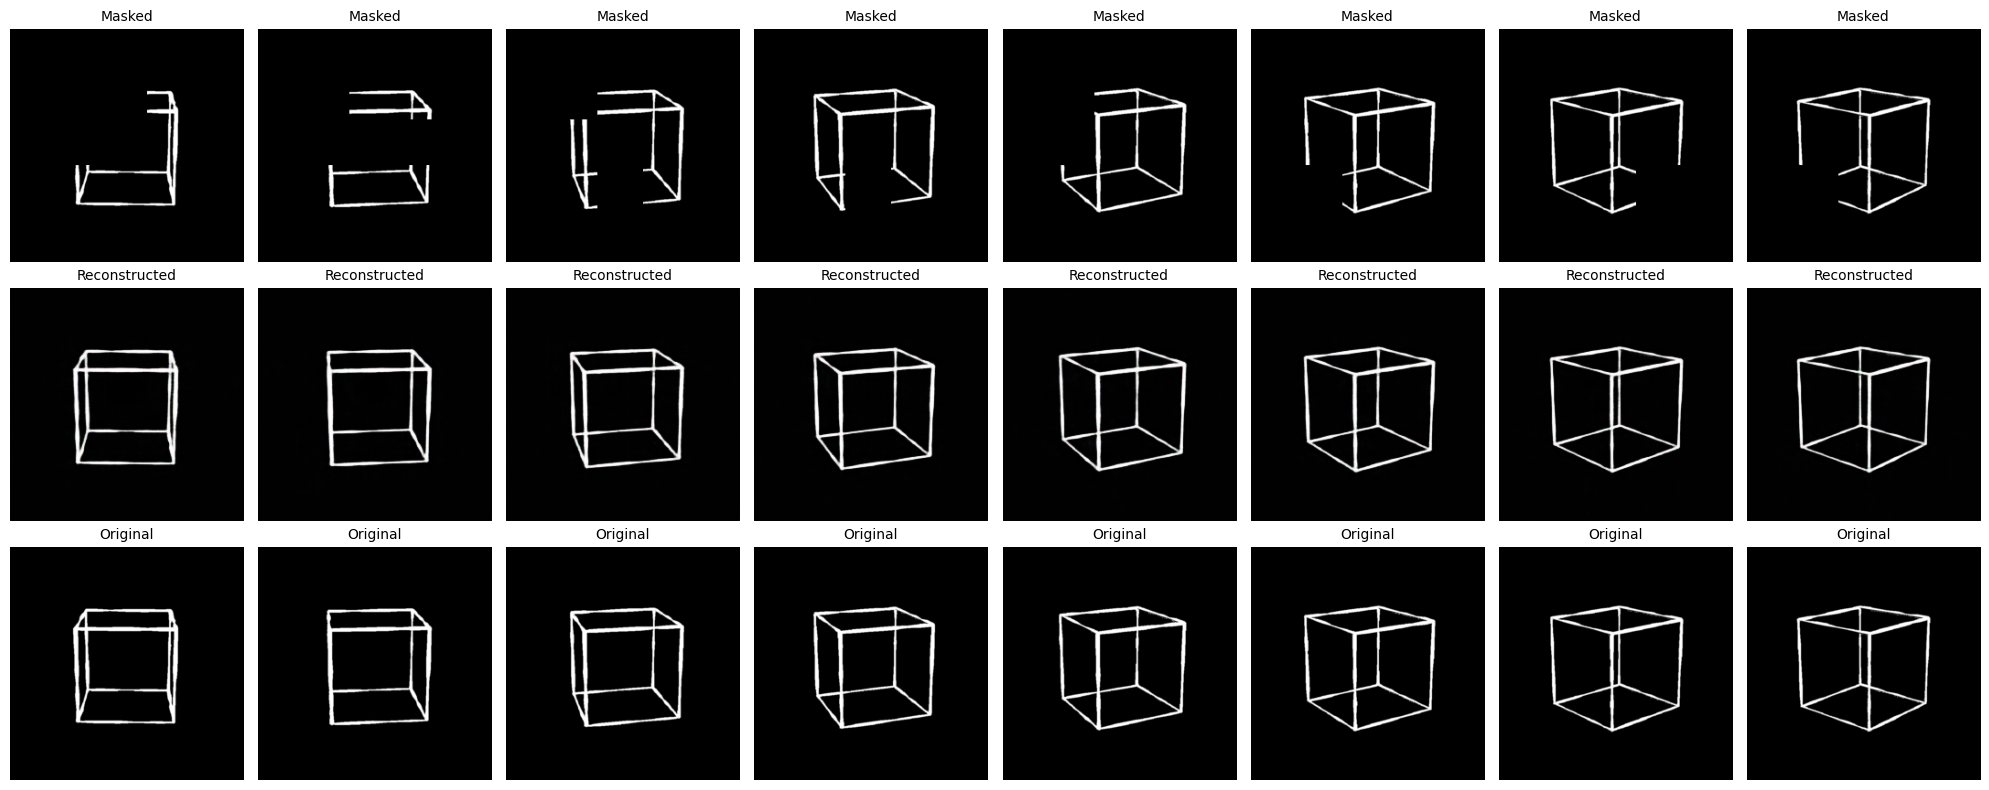

In [83]:

masked_imgs, original_imgs, names = next(iter(test_loader))

masked_imgs = masked_imgs.to(device)

with torch.no_grad():
    outputs = model(masked_imgs)

def denorm(t):
  return (t * 0.5 + 0.5).clamp(0, 1)

plt.figure(figsize=(20, 8))  # Augmente la taille de la figure

for i in range(8):
    # Ligne 1 : Masqué
    plt.subplot(3, 8, i + 1)
    plt.imshow(denorm(masked_imgs[i].cpu()).permute(1, 2, 0))
    plt.axis('off')
    plt.title("Masked", fontsize=10)  # Forcer un titre visible

    # Ligne 2 : Reconstruit
    plt.subplot(3, 8, i + 1 + 8)
    plt.imshow(denorm(outputs[i].cpu()).permute(1, 2, 0))
    plt.axis('off')
    plt.title("Reconstructed", fontsize=10)

    # Ligne 3 : Original
    plt.subplot(3, 8, i + 1 + 16)
    plt.imshow(denorm(original_imgs[i].cpu()).permute(1, 2, 0))
    plt.axis('off')
    plt.title("Original", fontsize=10)

plt.tight_layout()
plt.show()


## Save Images in differents directories

In [84]:
# import torch.nn.functional as F
# import shutil

# # Répertoire d’exportation
# output_dir = "C:/Users/bilel/Box_Line/render/Result"
# masked_dir = os.path.join(output_dir, "masked")
# recon_dir = os.path.join(output_dir, "reconstructed")
# original_dir = os.path.join(output_dir, "original")

# # Supprime les dossiers s'ils existent déjà
# for dir_path in [masked_dir, recon_dir, original_dir]:
#     if os.path.exists(dir_path):
#         shutil.rmtree(dir_path)  # Supprime le dossier et tout son contenu

# # Crée les dossiers s'ils n'existent pas
# os.makedirs(masked_dir, exist_ok=True)
# os.makedirs(recon_dir, exist_ok=True)
# os.makedirs(original_dir, exist_ok=True)

# # Fonction pour dénormaliser les images
# def denorm(tensor):
#     return (tensor * 0.5 + 0.5).clamp(0, 1)
    
# """
# def upscale_and_save(img_tensor, path, size=(1024, 1024)):
#     img = to_pil_image(denorm(img_tensor).clamp(0, 1))
#     img = img.resize(size, Image.LANCZOS)
#     img.save(path)
# """

# def upscale_and_save(img_tensor, path, size=(720, 720)):
#     img_tensor = denorm(img_tensor).unsqueeze(0)  # Ajoute batch dim
#     upscaled = F.interpolate(img_tensor, size=size, mode='bilinear', align_corners=False)
#     upscaled = upscaled.squeeze(0).clamp(0, 1)

#     img = to_pil_image(upscaled)
#     img.save(path)


# # Mode évaluation
# model.eval()

# # Boucle d’exportation
# with torch.no_grad():
#     img_id = 0
#     for masked_imgs, original_imgs, filenames in test_loader:  # Le Dataset doit renvoyer filenames
#         masked_imgs = masked_imgs.to(device)
#         original_imgs = original_imgs.to(device)
#         outputs = model(masked_imgs)

#         for i in range(masked_imgs.size(0)):
#             name = os.path.splitext(filenames[i])[0]  # Retire .png du nom

#             # Masqué
#             upscale_and_save(masked_imgs[i].cpu(), f"{masked_dir}/{name}_masked.png")

#             # Reconstruit
#             upscale_and_save(outputs[i].cpu(), f"{recon_dir}/{name}_reconstructed.png")

#             # Original
#             upscale_and_save(original_imgs[i].cpu(), f"{original_dir}/{name}_original.png")

#             img_id += 1

# print(f"Exporté {img_id} images masquées, reconstruites et originales.")



## Download files

In [85]:
##import shutil
##from google.colab import files

# Zip le dossier
##shutil.make_archive("/content/exports_all", 'zip', "\Box_Line\render\Dataset")

# Télécharger
##files.download("/content/exports_all.zip")
